### Ensemble model
#### I decided to ensemble different neural network architectures in order to obtain even more accurate predictions. In the first "naive" approach, predictions returned by the individual models are averaged and this averaging is the final prediction of the ensemble model. In a second, more complex, approach, I truncated the last n layers from the base models, concatenated them, and added a dense layer(s). After fine-tuning of the last layers, with frozen weights of the base models, we get aggregation more complicated than simple averaging. The ensemble model is characterized by more accurate estimations than the best-performing single model based on neural networksshown in earlier notebooks

In [1]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import optuna
import tensorflow as tf
from litter import WindowGenerator
from matplotlib.gridspec import GridSpec
from optuna.integration import TFKerasPruningCallback
from scipy.stats import gaussian_kde

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.style.use("bmh")

In [4]:
# WindowGenerator params
DATA_PATH = "../stations"
SCALING = "standarization"  # 'normalization'
GAP_STRATEGY = "linear"
FIRST_SEASON = 2015
FIRST_VAL_SEASON = 2021
FIRST_TEST_SEASON = 2022
LAST_TEST_SEASON = 2022

# data generator params
FEATURES = [
    "air_temperature_50cm",
    "air_temperature_200cm",
    "air_humidity_50cm",
    "air_humidity_200cm",
    "wind_x",
    "wind_y",
    "max_wind_x",
    "max_wind_y",
    "temporary_rainfall",
    "total_precipitation",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
]
DATA_FORMAT = "channels_last"
INTERVALS = [3, 6, 6 * 2, 6 * 4, 6 * 24, 6 * 24 * 12]
BASE_SEQ_LEN = 30
OTHER_SEQ_LEN = [30, 30, 30, 30, 30, 30]
INCLUDE_COORDS = True
USE_PREVIOUS_Y = True
REPLACE = False

# training params
BATCH_SIZE = 32

In [5]:
wg = WindowGenerator(
    data_path=DATA_PATH,
    scaling=SCALING,
    gap_strategy=GAP_STRATEGY,
    first_train_season=FIRST_SEASON,
    first_val_season=FIRST_VAL_SEASON,
    first_test_season=FIRST_TEST_SEASON,
    last_test_season=LAST_TEST_SEASON,
)

In [ ]:
(train_x, train_y), (val_x, val_y), (test_x, test_y), length_stats = wg.get_data(
    batch_size=BATCH_SIZE,
    data_format=DATA_FORMAT,
    intervals=INTERVALS,
    base_seq_len=BASE_SEQ_LEN,
    other_seq_len=OTHER_SEQ_LEN,
    features_cols=FEATURES,
    include_coords=INCLUDE_COORDS,
    use_previous_y=USE_PREVIOUS_Y,
    replace=REPLACE,
    train_generator=False,
    val_generator=False,
    test_generator=False,
)

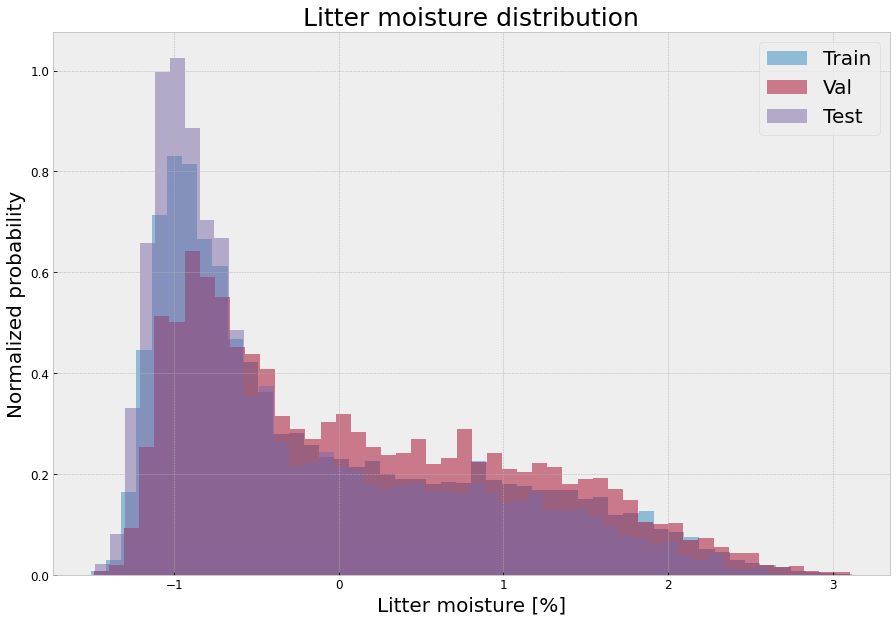

In [7]:
fig, ax = plt.subplots()

ax.hist(train_y, bins=50, density=True, label="Train", alpha=0.5)
ax.hist(val_y, bins=50, density=True, label="Val", alpha=0.5)
ax.hist(test_y, bins=50, density=True, label="Test", alpha=0.5)

plt.title("Litter moisture distribution", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_xlabel("Litter moisture [%]", fontsize=20)
ax.set_ylabel("Normalized probability", fontsize=20)
plt.legend(fontsize=20)
plt.savefig("litter_moisture_distribution_lstm.svg")

In [8]:
if SCALING == "normalization":
    train_y = (
        (wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]) * train_y
    ) + wg.train_min["litter_moisture"]
    val_y = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * val_y + wg.train_min["litter_moisture"]
    test_y = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * test_y + wg.train_min["litter_moisture"]

    y_morning_train = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * train_x[0][:, 0] + wg.train_min["litter_moisture"]
    y_morning_val = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * val_x[0][:, 0] + wg.train_min["litter_moisture"]
    y_morning_test = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * test_x[0][:, 0] + wg.train_min["litter_moisture"]

elif SCALING == "standarization":
    train_y = (
        train_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]
    )
    val_y = val_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]
    test_y = test_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]

    y_morning_train = (
        train_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )
    y_morning_val = (
        val_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )
    y_morning_test = (
        test_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )

else:
    y_morning_train = train_x[0][:, 0]
    y_morning_val = val_x[0][:, 0]
    y_morning_test = test_x[0][:, 0]

pct_change_train = (train_y - y_morning_train) / y_morning_train * 100
pct_change_val = (val_y - y_morning_val) / y_morning_val * 100
pct_change_test = (test_y - y_morning_test) / y_morning_test * 100

pct_change_mean = pct_change_train.mean()
pct_change_std = pct_change_train.std()

pct_change_standarized_train = (pct_change_train - pct_change_mean) / pct_change_std
pct_change_standarized_val = (pct_change_val - pct_change_mean) / pct_change_std
pct_change_standarized_test = (pct_change_test - pct_change_mean) / pct_change_std

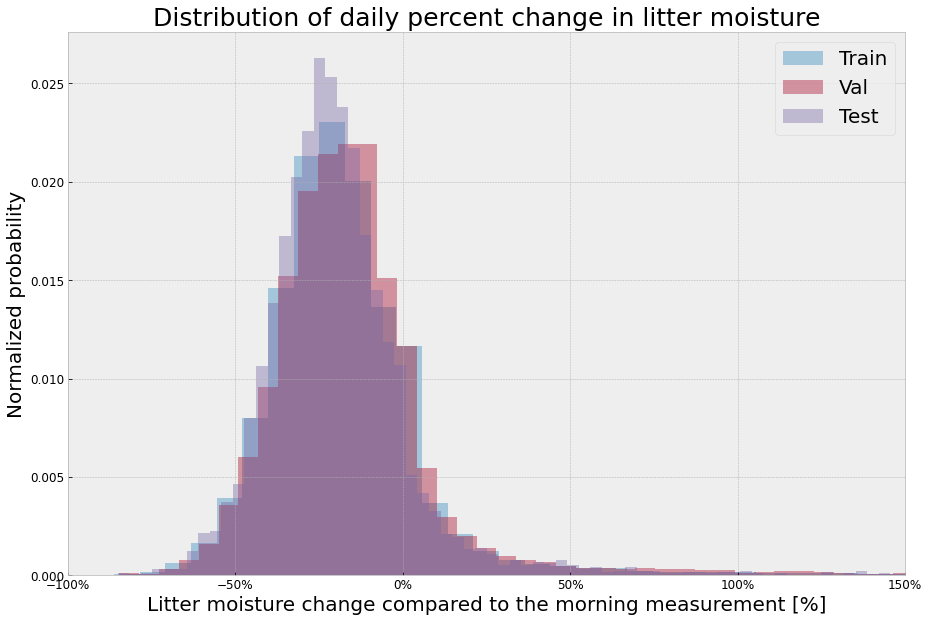

In [9]:
fig, ax = plt.subplots()

ax.hist(pct_change_train, bins=150, density=True, label="Train", alpha=0.4)
ax.hist(pct_change_val, bins=150, density=True, label="Val", alpha=0.4)
ax.hist(pct_change_test, bins=150, density=True, label="Test", alpha=0.4)

plt.xlim([-100, 150])
plt.title("Distribution of daily percent change in litter moisture", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax.set_xlabel(
    "Litter moisture change compared to the morning measurement [%]", fontsize=20
)
ax.set_ylabel("Normalized probability", fontsize=20)
plt.legend(fontsize=20)
plt.savefig("litter_moisture_change_lstm.svg")

In [22]:
# Load particular models

model_lstm = tf.keras.models.load_model("best_custom_lstm_pct_std")
model_conv = tf.keras.models.load_model("best_custom_conv_pct_std")
model_conv_lstm = tf.keras.models.load_model("best_custom_conv_lstm_pct_std")
model_dense = tf.keras.models.load_model("best_mdape_dense_pct_std")
model_transformer = tf.keras.models.load_model("best_custom_transformer_pct_std")

In [23]:
lstm_predictions = model_lstm.predict(test_x).flatten()
conv_predictions = model_conv.predict(test_x).flatten()
conv_lstm_predictions = model_conv_lstm.predict(test_x).flatten()
dense_predictions = model_dense.predict(test_x).flatten()
transformer_predictions = model_transformer.predict(test_x).flatten()

272/272 [==============================] - 5s 13ms/step


In [35]:
lstm_pct_change_predicted = lstm_predictions * pct_change_std + pct_change_mean
conv_pct_change_predicted = conv_predictions * pct_change_std + pct_change_mean
conv_lstm_pct_change_predicted = (
    conv_lstm_predictions * pct_change_std + pct_change_mean
)
dense_pct_change_predicted = dense_predictions * pct_change_std + pct_change_mean
transformer_pct_change_predicted = (
    transformer_predictions * pct_change_std + pct_change_mean
)

pct_change_predicted = (
    lstm_pct_change_predicted
    + conv_pct_change_predicted
    + conv_lstm_pct_change_predicted
    + dense_pct_change_predicted
    + transformer_pct_change_predicted
) / 5


y_real = y_morning_test * (1 + pct_change_test / 100)
y_pred = y_morning_test * (1 + pct_change_predicted / 100)

mae = np.absolute(y_real - y_pred).mean()
rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
mape = np.abs((y_real - y_pred) / y_real).mean() * 100
mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
print(mae, rmsd, mape, mdape)

3.277617759472093 5.151483820417164 15.57251903747029 10.679300913793078


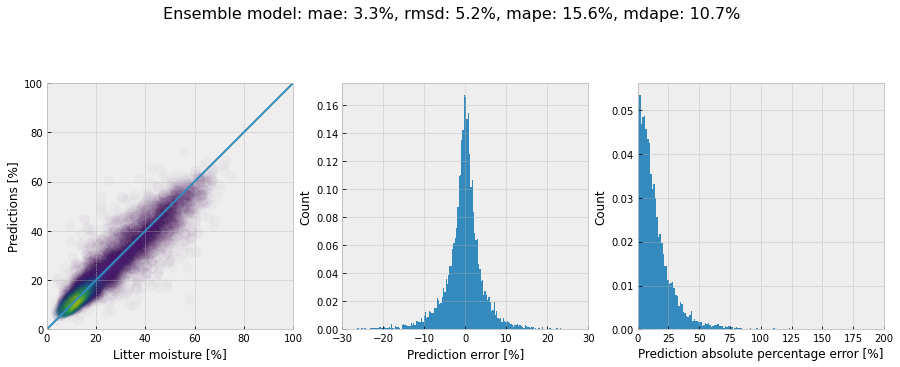

In [38]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([y_real, y_pred])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(nrows=1, ncols=3)
_ = fig.suptitle(
    f"Ensemble model: mae: {round(mae, 1)}%, rmsd: {round(rmsd, 1)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%",
    fontsize=16,
    y=0.78,
)

_ = ax[0].set_aspect("equal")
ax[0].scatter(y_real, y_pred, c=z, s=100, alpha=0.02)
ax[0].set_xlabel("Litter moisture [%]")
ax[0].set_ylabel("Predictions [%]")
lims = [0, 100]
ax[0].plot(lims, lims)
_ = ax[0].axis(xmin=0, xmax=100, ymin=0, ymax=100)


error = y_pred - y_real
ax[1].hist(error, bins=300, density=True)
ax[1].set_xlim([-30, 30])
ax[1].set_xlabel("Prediction error [%]")
_ = ax[1].set_ylabel("Count")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
_ = ax[1].set_aspect(asp)


error = np.absolute((y_pred - y_real) / y_real) * 100
ax[2].hist(error, bins=300, density=True)
ax[2].set_xlim([0, 200])
ax[2].set_xlabel("Prediction absolute percentage error [%]")
_ = ax[2].set_ylabel("Count")
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
_ = ax[2].set_aspect(asp)


plt.savefig("litter_moisture_lstm_test_ensemble.svg")

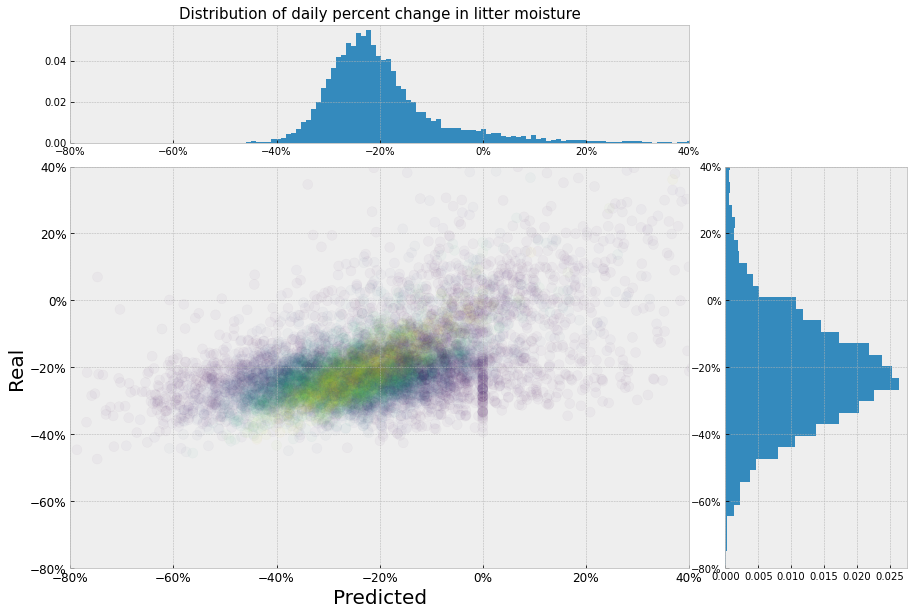

<Figure size 1080x720 with 0 Axes>

In [120]:
fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0, 0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(pct_change_test, pct_change_predicted, c=z, s=100, alpha=0.03)
ax_hist_x.hist(pct_change_test, orientation="horizontal", bins=150, density=True)
ax_hist_y.hist(pct_change_predicted, bins=500, density=True)

ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_y.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_x.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.set_ylabel("Real", fontsize=20)
ax_scatter.set_xlabel("Predicted", fontsize=20)

min_val, max_val = -80, 40
ax_scatter.set_xlim([min_val, max_val])
ax_scatter.set_ylim([min_val, max_val])
ax_hist_y.set_xlim([min_val, max_val])
ax_hist_x.set_ylim([min_val, max_val])
ax_hist_y.set_title(
    "Distribution of daily percent change in litter moisture", fontsize=15
)
ax_scatter.tick_params(axis="both", which="major", labelsize=12)
ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

plt.show()
plt.savefig("results_boundary_pct_change_distribution_ensemble.svg")

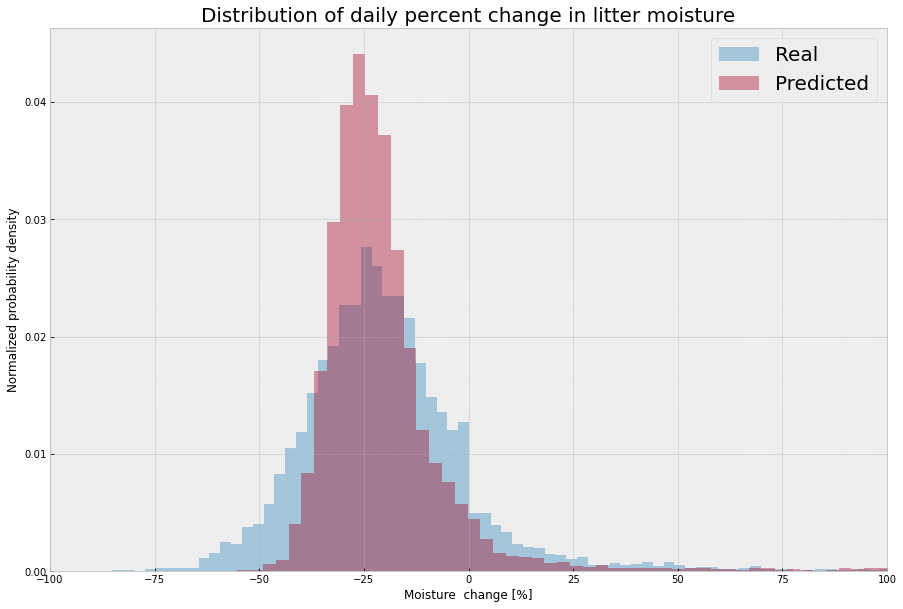

In [40]:
_ = plt.hist(pct_change_test, bins=200, density=True, alpha=0.4, label="Real")
_ = plt.hist(pct_change_predicted, bins=150, density=True, alpha=0.4, label="Predicted")
plt.legend(fontsize=20)
plt.xlim([-100, 100])
plt.xlabel("Moisture  change [%]")
plt.ylabel("Normalized probability density")
_ = plt.title("Distribution of daily percent change in litter moisture", fontsize=20)

In [112]:
model_lstm._name = "model_lstm"
model_conv._name = "model_conv"
model_conv_lstm._name = "model_conv_lstm"
model_transformer._name = "model_transformer"
model_dense._name = "model_dense"

model_lstm.trainable = False
model_conv.trainable = False
model_conv_lstm.trainable = False
model_transformer.trainable = False
model_dense.trainable = False


def get_ensemble_model(layers_to_cut=1):

    if OTHER_SEQ_LEN:
        sequences_n = OTHER_SEQ_LEN
    else:
        sequences_n = [BASE_SEQ_LEN for _ in range(INTERVALS)]

    features_n = len(FEATURES)
    sequence_inputs = [
        tf.keras.Input(shape=(seq_n, features_n), name=f"seq_input_{str(i)}")
        for i, seq_n in enumerate(sequences_n)
    ]
    dense_inputs_len = 1 if USE_PREVIOUS_Y else 0
    dense_inputs_len += 2 if INCLUDE_COORDS else 0
    if dense_inputs_len:
        dense_inputs = tf.keras.Input(shape=(dense_inputs_len), name="dense_input")
    else:
        dense_inputs = None

    x_lstm = tf.keras.models.Model(
        inputs=model_lstm.input, outputs=model_lstm.layers[-1 - layers_to_cut].output
    )([dense_inputs, *sequence_inputs])
    x_conv = tf.keras.models.Model(
        inputs=model_conv.input, outputs=model_conv.layers[-1 - layers_to_cut].output
    )([dense_inputs, *sequence_inputs])
    x_conv_lstm = tf.keras.models.Model(
        inputs=model_conv_lstm.input,
        outputs=model_conv_lstm.layers[-1 - layers_to_cut].output,
    )([dense_inputs, *sequence_inputs])
    x_transformer = tf.keras.models.Model(
        inputs=model_transformer.input,
        outputs=model_transformer.layers[-1 - layers_to_cut].output,
    )([dense_inputs, *sequence_inputs])
    x_dense = tf.keras.models.Model(
        inputs=model_dense.input, outputs=model_dense.layers[-1 - layers_to_cut].output
    )([dense_inputs, *sequence_inputs])

    x = tf.keras.layers.concatenate(
        [x_lstm, x_conv, x_conv_lstm, x_transformer, x_dense]
    )

    batch_norm = tf.keras.layers.BatchNormalization()(x)
    dropout = tf.keras.layers.Dropout(0.5)(batch_norm)
    outputs = tf.keras.layers.Dense(1)(dropout)

    model = tf.keras.models.Model(
        inputs=[dense_inputs, *sequence_inputs], outputs=outputs
    )
    return model

In [113]:
ensemble_model = get_ensemble_model(layers_to_cut=3)
ensemble_model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_input (InputLayer)       [(None, 3)]          0           []                               
                                                                                                  
 seq_input_0 (InputLayer)       [(None, 30, 14)]     0           []                               
                                                                                                  
 seq_input_1 (InputLayer)       [(None, 30, 14)]     0           []                               
                                                                                                  
 seq_input_2 (InputLayer)       [(None, 30, 14)]     0           []                               
                                                                                           

In [99]:
tf.keras.utils.plot_model(
    ensemble_model, "model.png", show_shapes=True, expand_nested=True, show_dtype=True
)

In [124]:
ensemble_model = get_ensemble_model(layers_to_cut=1)

In [125]:
ensemble_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00008),
    loss=tf.keras.losses.Huber(0.65),
)


es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

history = ensemble_model.fit(
    x=train_x,
    y=pct_change_standarized_train,
    epochs=500,
    validation_data=(val_x, pct_change_standarized_val),
    callbacks=[es],
)

Epoch 1/500
1904/1904 [==============================] - 262s 96ms/step - loss: 0.3622 - val_loss: 0.1424
Epoch 2/500
1904/1904 [==============================] - 154s 81ms/step - loss: 0.1953 - val_loss: 0.1411
Epoch 3/500
1904/1904 [==============================] - 155s 81ms/step - loss: 0.1368 - val_loss: 0.1367
Epoch 4/500
1904/1904 [==============================] - 154s 81ms/step - loss: 0.1219 - val_loss: 0.1351
Epoch 5/500
1904/1904 [==============================] - 155s 81ms/step - loss: 0.1195 - val_loss: 0.1350
Epoch 6/500
1904/1904 [==============================] - 154s 81ms/step - loss: 0.1188 - val_loss: 0.1380
Epoch 7/500
1904/1904 [==============================] - 154s 81ms/step - loss: 0.1174 - val_loss: 0.1342
Epoch 8/500
1904/1904 [==============================] - 154s 81ms/step - loss: 0.1178 - val_loss: 0.1334
Epoch 9/500
1904/1904 [==============================] - 154s 81ms/step - loss: 0.1181 - val_loss: 0.1373
Epoch 10/500
1904/1904 [======================

In [ ]:
tf.keras.models.save_model(ensemble_model, "best_custom_ensemble_finetuned_pct_std")
ensemble_predictions = ensemble_model.predict(test_x).flatten()

In [127]:
pct_change_predicted = ensemble_predictions * pct_change_std + pct_change_mean

y_real = y_morning_test * (1 + pct_change_test / 100)
y_pred = y_morning_test * (1 + pct_change_predicted / 100)

mae = np.absolute(y_real - y_pred).mean()
rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
mape = np.abs((y_real - y_pred) / y_real).mean() * 100
mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
print(mae, rmsd, mape, mdape)

3.4036822924049437 6.057124280468649 16.09481377738753 10.891014663517193


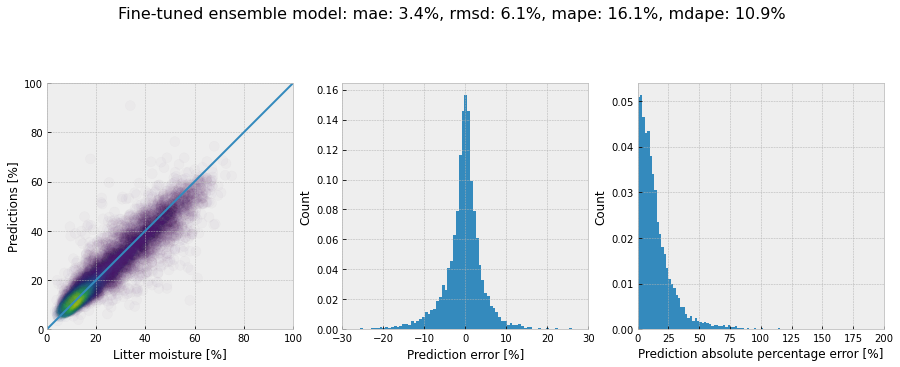

In [128]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([y_real, y_pred])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(nrows=1, ncols=3)
_ = fig.suptitle(
    f"Fine-tuned ensemble model: mae: {round(mae, 1)}%, rmsd: {round(rmsd, 1)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%",
    fontsize=16,
    y=0.78,
)

_ = ax[0].set_aspect("equal")
ax[0].scatter(y_real, y_pred, c=z, s=100, alpha=0.02)
ax[0].set_xlabel("Litter moisture [%]")
ax[0].set_ylabel("Predictions [%]")
lims = [0, 100]
ax[0].plot(lims, lims)
_ = ax[0].axis(xmin=0, xmax=100, ymin=0, ymax=100)


error = y_pred - y_real
ax[1].hist(error, bins=300, density=True)
ax[1].set_xlim([-30, 30])
ax[1].set_xlabel("Prediction error [%]")
_ = ax[1].set_ylabel("Count")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
_ = ax[1].set_aspect(asp)


error = np.absolute((y_pred - y_real) / y_real) * 100
ax[2].hist(error, bins=300, density=True)
ax[2].set_xlim([0, 200])
ax[2].set_xlabel("Prediction absolute percentage error [%]")
_ = ax[2].set_ylabel("Count")
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
_ = ax[2].set_aspect(asp)


plt.savefig("litter_moisture_lstm_test_finetuned_ensemble.svg")

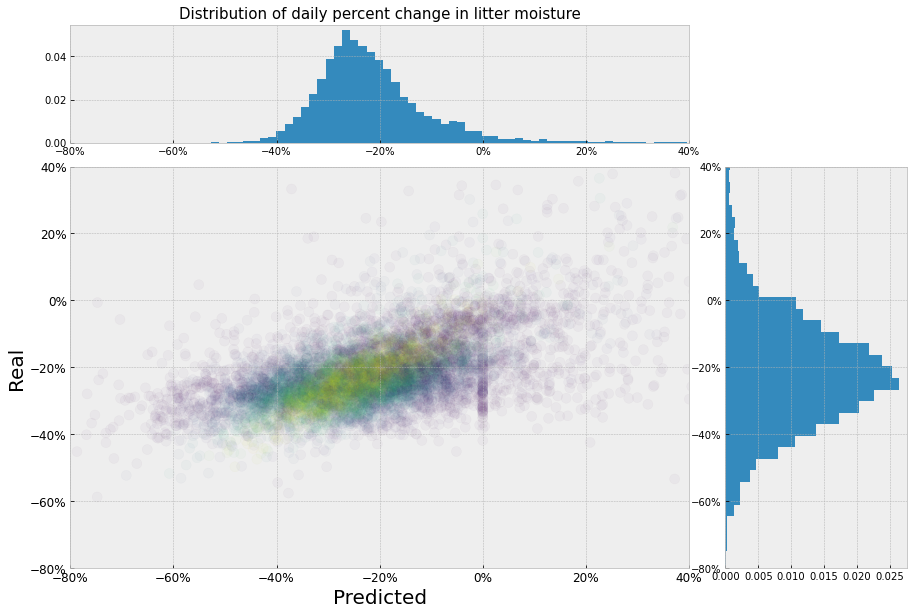

<Figure size 1080x720 with 0 Axes>

In [129]:
fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0, 0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(pct_change_test, pct_change_predicted, c=z, s=100, alpha=0.03)
ax_hist_x.hist(pct_change_test, orientation="horizontal", bins=150, density=True)
ax_hist_y.hist(pct_change_predicted, bins=500, density=True)

ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_y.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_x.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.set_ylabel("Real", fontsize=20)
ax_scatter.set_xlabel("Predicted", fontsize=20)

min_val, max_val = -80, 40
ax_scatter.set_xlim([min_val, max_val])
ax_scatter.set_ylim([min_val, max_val])
ax_hist_y.set_xlim([min_val, max_val])
ax_hist_x.set_ylim([min_val, max_val])
ax_hist_y.set_title(
    "Distribution of daily percent change in litter moisture", fontsize=15
)
ax_scatter.tick_params(axis="both", which="major", labelsize=12)
ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

plt.show()
plt.savefig("results_boundary_pct_change_distribution_finetuned_ensemble.svg")

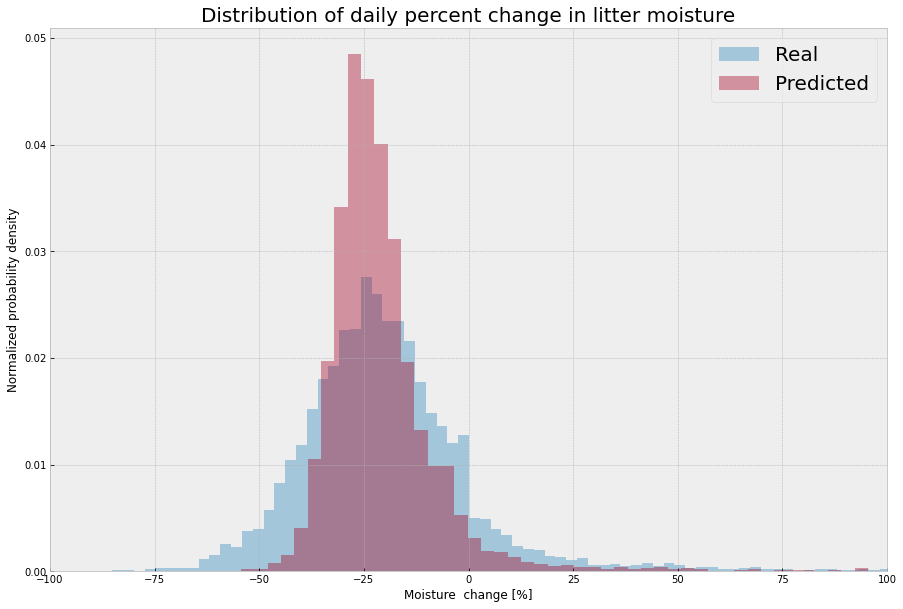

In [130]:
_ = plt.hist(pct_change_test, bins=200, density=True, alpha=0.4, label="Real")
_ = plt.hist(pct_change_predicted, bins=250, density=True, alpha=0.4, label="Predicted")
plt.legend(fontsize=20)
plt.xlim([-100, 100])
plt.xlabel("Moisture  change [%]")
plt.ylabel("Normalized probability density")
_ = plt.title("Distribution of daily percent change in litter moisture", fontsize=20)